<a href="https://colab.research.google.com/github/fatiha-izmouh/Analyse_sentiment/blob/main/Mini_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Collecte de donnees

In [1]:
pip install googletrans

In [2]:
pip install textblob

In [3]:
pip install beautifulsoup4 requests deep-translator textblob pandas


In [4]:
from bs4 import BeautifulSoup
import requests
import json
import csv
from deep_translator import GoogleTranslator
from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
import string

In [5]:

url = "https://www.hespress.com/"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
  #categorie
def sc_categories(main_url):
    response = requests.get(main_url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    categories = []
    for link in soup.find_all('li', class_='menu-item nav-item')[1:]:
        a_tag = link.find('a', class_='nav-link')
        if a_tag:
            category_url = a_tag['href']
            category_name = a_tag.get_text(strip=True)
            categories.append({
                'category_name': category_name,
                'category_url': category_url
            })

    return categories

In [7]:
#article
def sc_articles(category_url):
    response = requests.get(category_url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    articles = []
    for link in soup.find_all('a', class_='stretched-link')[:5]:
        article_url = link['href']
        article_title = link.get('title', 'No Title')
        comments = sc_comments(article_url)

        articles.append({
            'url': article_url,
            'title': article_title,
            'comments': comments
        })

    return articles

In [8]:
#comments
def sc_comments(article_url):
    response = requests.get(article_url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    comments = []
    comment_elements = soup.find_all('div', class_='comment-text')

    for element in comment_elements[:10]:
        comment_texts = element.find_all('p')
        comment = '\n'.join(text.get_text(separator="\n", strip=True) for text in comment_texts)
        translated_comment = translate_to_french(comment)
        preprocessed_comment = preprocess_comment(translated_comment)
        sentiment = analyze_sentiment(preprocessed_comment)
        comments.append({
            'comment': translated_comment,
            'cleaned comments':preprocessed_comment,
            'sentiment': sentiment
        })

    return comments

In [9]:
#traduction
def translate_to_french(text):
    try:
        translation = GoogleTranslator(source='auto', target='fr').translate(text)
        return translation
    except Exception as e:
        print(f"Translation failed: {e}")
        return text

In [10]:
#nettoyage
def tokenize_com(text):
    return word_tokenize(text)

def lemmatize_com(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def stem_com(tokens):
    stemmer = FrenchStemmer()
    return [stemmer.stem(token) for token in tokens]

In [11]:
#nettoyage
def clean_comment(comment):
  stop_words = set(stopwords.words('french'))
  comment = comment.lower()
  comment = ''.join([char for char in comment if char not in string.punctuation and not char.isdigit()])
  comment = ' '.join([word for word in comment.split() if word not in stop_words])
  return comment

In [12]:
#nettoyage
def preprocess_comment(comment):
    cleaned_comment = clean_comment(comment)
    tokens = tokenize_com(cleaned_comment)
    lemmatized_tokens = lemmatize_com(tokens)
    stemmed_tokens = stem_com(lemmatized_tokens)
    return ' '.join(stemmed_tokens)

In [13]:
#sentiment
def analyze_sentiment(text):
    try:
        blob = TextBlob(text)
        if blob.sentiment.polarity > 0.1:
            return 'positif'
        elif blob.sentiment.polarity < -0.1:
            return 'negatif'
        else:
            return 'neutral'
    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        return 'neutral'

In [14]:
categories = sc_categories(url)

articles_data = []
for category in categories:
    articles = sc_articles(category['category_url'])
    for article in articles:
        articles_data.append({
            'category': category['category_name'],
            'url': article['url'],
            'title': article['title'],
            'comments': article['comments']
        })
#  CSV
with open('cleaned_comments.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['category', 'url', 'title', 'comment','cleaned comment','sentiment']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for article in articles_data:
        for comment_data in article['comments']:
            writer.writerow({
                'category': translate_to_french(article['category']),
                'url': article['url'],
                'title': translate_to_french(article['title']),
                'comment': comment_data['comment'],
                'cleaned comment':comment_data['cleaned comments'],
                'sentiment': comment_data['sentiment']
            })

print("Data has been scraped and cleaned, and saved to cleaned_comments.csv")

Translation failed: Request exception can happen due to an api connection error. Please check your connection and try again
Translation failed: Request exception can happen due to an api connection error. Please check your connection and try again
Translation failed: Request exception can happen due to an api connection error. Please check your connection and try again
Translation failed: Request exception can happen due to an api connection error. Please check your connection and try again
Translation failed: Request exception can happen due to an api connection error. Please check your connection and try again
Translation failed: Request exception can happen due to an api connection error. Please check your connection and try again
Translation failed: Request exception can happen due to an api connection error. Please check your connection and try again
Translation failed: Request exception can happen due to an api connection error. Please check your connection and try again
Translat

**Exploitation des données **

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
df = pd.read_csv('cleaned_comments.csv')

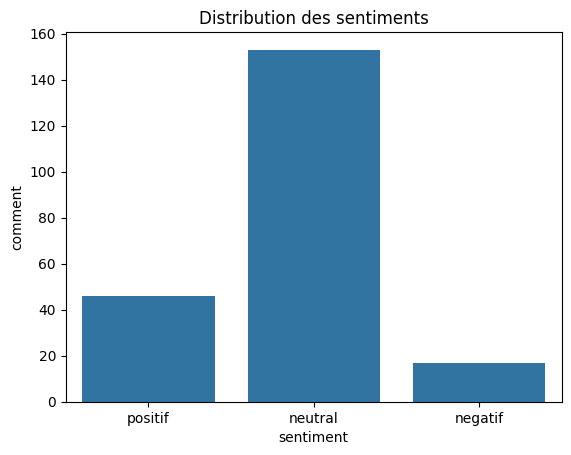

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution des sentiments
sns.countplot(x='sentiment', data=df)
plt.title('Distribution des sentiments')
plt.xlabel('sentiment')
plt.ylabel('comment')
plt.show()


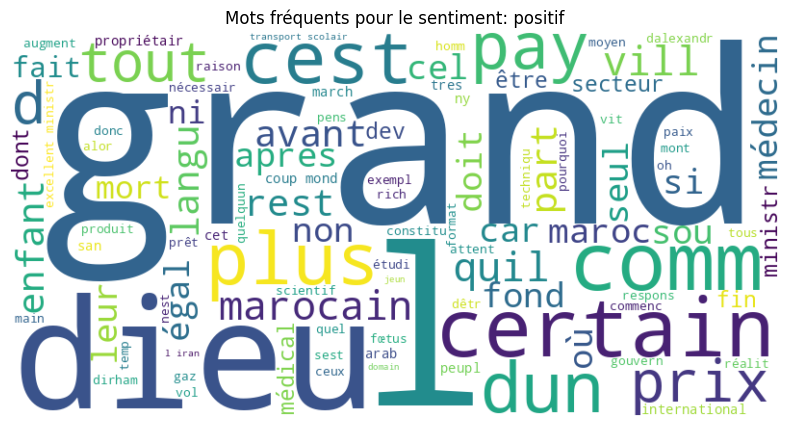

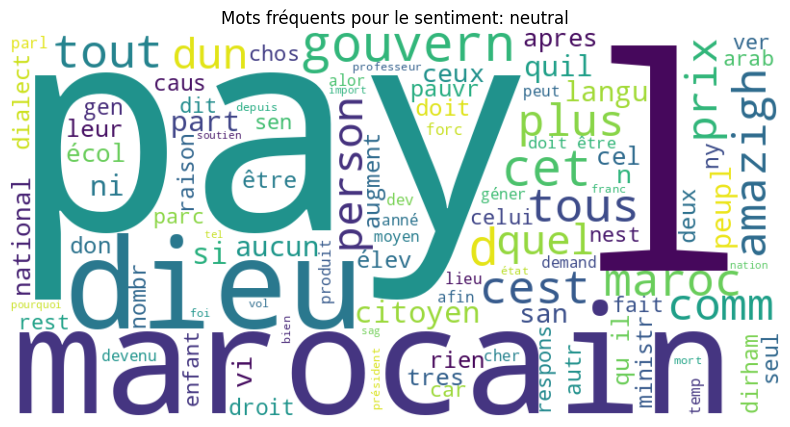

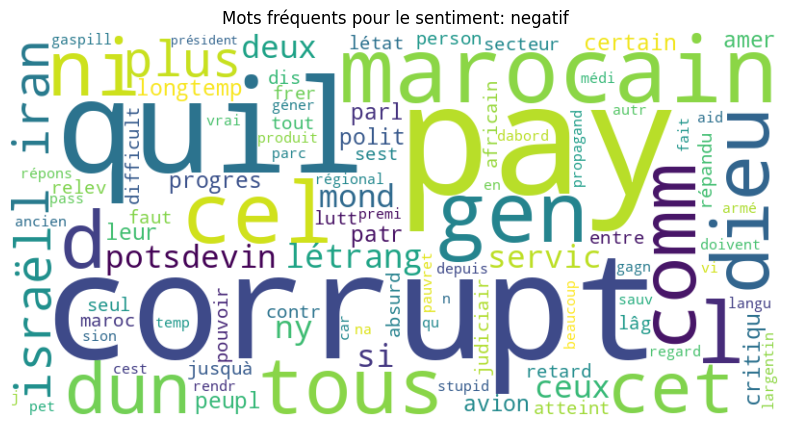

In [17]:
from wordcloud import WordCloud

#  les mots les plus fréquents
def plot_word_freq(data, sentiment_label):
    words = ' '.join(data[data['sentiment'] == sentiment_label]['cleaned comment'])
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Mots fréquents pour le sentiment: {sentiment_label}')
    plt.axis('off')
    plt.show()

# Affichage
for sentiment in df['sentiment'].unique():
    plot_word_freq(df, sentiment)


**Entraınement du modele**

In [22]:
from sklearn.preprocessing import LabelEncoder

In [29]:
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(df['cleaned comment'], df['sentiment_encoded'], test_size=0.2, random_state=42)c
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

Mean Squared Error: 0.3015332765403068
R2 Score: 0.052323988016178546
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.68      1.00      0.81        30
           2       0.00      0.00      0.00         7

    accuracy                           0.68        44
   macro avg       0.23      0.33      0.27        44
weighted avg       0.46      0.68      0.55        44



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
